In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
print(tf.__version__)
print(sys.version_info)
for module in np,pd,tf,tf.keras:
    print(module.__name__,module.__version__)

2.5.0
sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
numpy 1.19.2
pandas 1.1.3
tensorflow 2.5.0
tensorflow.keras 2.5.0


In [3]:
from pathlib import Path
train_path = Path("training")
filepath = list(train_path.glob(r'**/*.jpg'))

test_path = Path("validation")
filepath_test = list(test_path.glob(r'**/*.jpg'))

In [4]:
classes = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepath))
classes_test = list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepath_test))

In [5]:
df = pd.concat([pd.Series(filepath).astype(str), pd.Series(classes)], axis=1)
df.columns = ['Images', 'Image_label']

df_test = pd.concat([pd.Series(filepath_test).astype(str), pd.Series(classes_test)], axis=1)
df_test.columns = ['Images', 'Image_label']

In [6]:
df.head()

,Images,Image_label
0,training\training\alouatta_palliata\n0018.jpg,alouatta_palliata
1,training\training\alouatta_palliata\n0019.jpg,alouatta_palliata
2,training\training\alouatta_palliata\n0020.jpg,alouatta_palliata
3,training\training\alouatta_palliata\n0021.jpg,alouatta_palliata
4,training\training\alouatta_palliata\n0022.jpg,alouatta_palliata


In [7]:
df.shape

(1096, 2)

In [8]:
df_test.shape

(272, 2)

<AxesSubplot:>

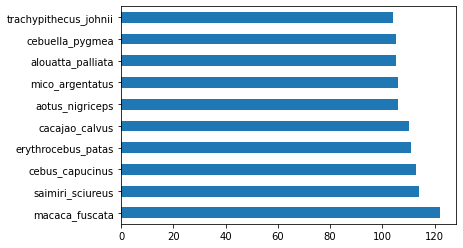

In [9]:
df.Image_label.value_counts()

df.Image_label.value_counts().plot(kind='barh',x='Images',y='Image_label')

<AxesSubplot:>

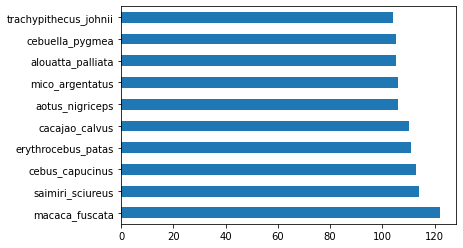

In [10]:
df_test.Image_label.value_counts()


df.Image_label.value_counts().plot(kind='barh',x='Images',y='Image_label')

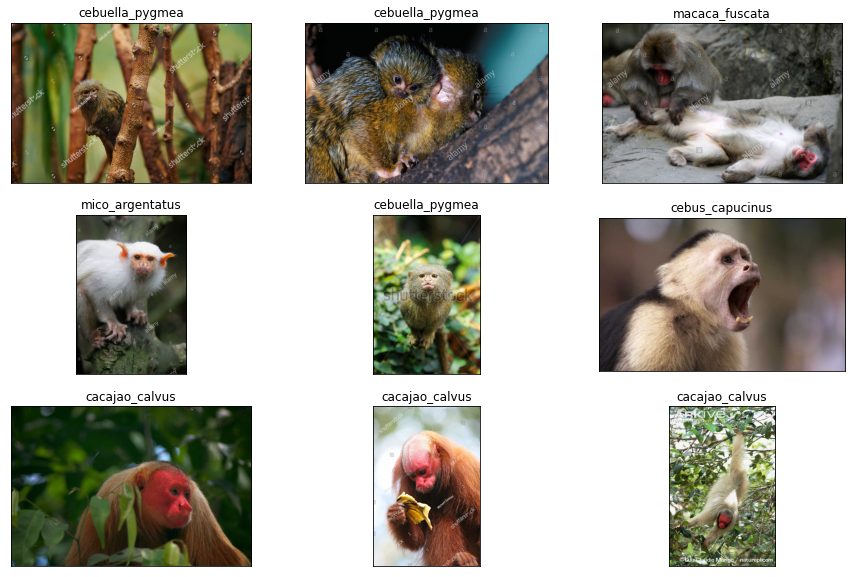

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
random_images = np.random.randint(0,df.shape[0],9)
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Images[random_images[i]]))
    ax.set_title(df.Image_label[random_images[i]])
    
plt.show()

In [12]:
train = df
test = df_test

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255.,
                                    rotation_range = 40,
                                    width_shift_range = 0.2, 
                                    height_shift_range = 0.2, 
                                    shear_range = 0.2, 
                                    zoom_range = 0.2, 
                                    horizontal_flip = True, 
                                    vertical_flip =True)

test_datagen = ImageDataGenerator(rescale = 1./255.)

In [14]:
height = 224
width = 224
channels = 3
batch_size = 64
num_class  = 10

In [15]:
train_gen = train_datagen.flow_from_dataframe(train,
                                              x_col = 'Images', y_col ='Image_label',
                                              target_size = (height, width), batch_size = batch_size, 
                                              class_mode = 'categorical', shuffle = True)

test_gen = test_datagen.flow_from_dataframe(test,
                                            target_size = (height, width), x_col = 'Images', y_col ='Image_label',
                                             class_mode = 'categorical',
                                            batch_size = batch_size, shuffle = False)

Found 1096 validated image filenames belonging to 10 classes.
Found 272 validated image filenames belonging to 10 classes.


In [16]:
train_gen.class_indices

{'alouatta_palliata': 0,
 'aotus_nigriceps': 1,
 'cacajao_calvus': 2,
 'cebuella_pygmea': 3,
 'cebus_capucinus': 4,
 'erythrocebus_patas': 5,
 'macaca_fuscata': 6,
 'mico_argentatus': 7,
 'saimiri_sciureus': 8,
 'trachypithecus_johnii': 9}

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam

base_model = tf.keras.applications.ResNet50V2(weights='imagenet',
                                             input_shape = (height, width, channels),
                                            include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
base_model.summary()

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256))
model.add(Dropout(0.2))
model.add(Dense(num_class, activation = 'softmax'))
model.summary()

callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

eact_relu (Activ (None, 14, 14, 1024) 0           conv4_block2_preact_bn[0][0]     
__________________________________________________________________________________________________
conv4_block2_1_conv (Conv2D)    (None, 14, 14, 256)  262144      conv4_block2_preact_relu[0][0]   
__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 14, 14, 256)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_pad (ZeroPadding (None, 16, 16, 256)  0           conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv

In [18]:
history = model.fit(train_gen,
                    validation_data=test_gen,
                    epochs = 25,
                    callbacks = [callbacks],
                    shuffle=True,
                    verbose = 1)

Epoch 1/25
18/18 [==============================] - 36s 2s/step - loss: 2.1593 - accuracy: 0.4982 - val_loss: 0.2034 - val_accuracy: 0.9375
Epoch 2/25
18/18 [==============================] - 29s 2s/step - loss: 0.5193 - accuracy: 0.8385 - val_loss: 0.1910 - val_accuracy: 0.9485
Epoch 3/25
18/18 [==============================] - 30s 2s/step - loss: 0.5149 - accuracy: 0.8568 - val_loss: 0.1357 - val_accuracy: 0.9596
Epoch 4/25
18/18 [==============================] - 29s 2s/step - loss: 0.5153 - accuracy: 0.8568 - val_loss: 0.1327 - val_accuracy: 0.9596
Epoch 5/25
18/18 [==============================] - 30s 2s/step - loss: 0.4939 - accuracy: 0.8595 - val_loss: 0.1957 - val_accuracy: 0.9449
Epoch 6/25
18/18 [==============================] - 29s 2s/step - loss: 0.4053 - accuracy: 0.8841 - val_loss: 0.1569 - val_accuracy: 0.9485


In [19]:
model.save('my_model.h5')

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [20]:
accuracy = history.history['accuracy']
loss = history.history['loss']
validation = history.history['val_accuracy']
validation_loss = history.history['val_loss']

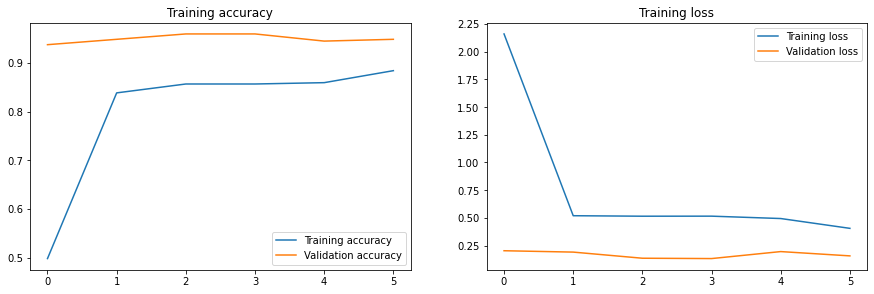

In [21]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(validation, label = "Validation accuracy")

plt.legend()
plt.title("Training accuracy")


plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(validation_loss, label = "Validation loss")

plt.legend()
plt.title("Training loss")

plt.show()

In [22]:
predictions = model.predict(test_gen)
preds = np.argmax(predictions, axis=1)
preds

array([0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 8, 1, 1, 1, 1, 2, 8, 2, 2, 2, 2, 6, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 6, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 4, 4, 4, 4, 4, 4,
       4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       6, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 5, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 7, 7, 7, 7, 6,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 8, 8,
       8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8,
       8, 8, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9,
       9, 9, 9, 9, 9, 9, 9, 9], dtype=int64)

In [23]:
labels = train_gen.class_indices
labels

{'alouatta_palliata': 0,
 'aotus_nigriceps': 1,
 'cacajao_calvus': 2,
 'cebuella_pygmea': 3,
 'cebus_capucinus': 4,
 'erythrocebus_patas': 5,
 'macaca_fuscata': 6,
 'mico_argentatus': 7,
 'saimiri_sciureus': 8,
 'trachypithecus_johnii': 9}

In [24]:
labels = dict((v,k) for k,v in labels.items())
labels

{0: 'alouatta_palliata',
 1: 'aotus_nigriceps',
 2: 'cacajao_calvus',
 3: 'cebuella_pygmea',
 4: 'cebus_capucinus',
 5: 'erythrocebus_patas',
 6: 'macaca_fuscata',
 7: 'mico_argentatus',
 8: 'saimiri_sciureus',
 9: 'trachypithecus_johnii'}

In [25]:
preds = [labels[k] for k in preds]

In [26]:
from sklearn.metrics import confusion_matrix
matrix = confusion_matrix(test.Image_label , preds)
matrix

array([[23,  0,  0,  0,  0,  0,  0,  0,  0,  3],
       [ 0, 25,  0,  0,  0,  0,  0,  0,  2,  0],
       [ 0,  0, 25,  0,  0,  0,  1,  0,  1,  0],
       [ 0,  0,  0, 26,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 26,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 27,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2, 28,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1, 24,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 28,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 26]], dtype=int64)

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(test.Image_label, preds)

0.9485294117647058